In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [3]:
data = loadmat('ex4data1.mat')
X=data.get('X')
y=data.get('y')



In [4]:
def plot_100_image(X):
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]
    size = int(np.sqrt(X.shape[1]))
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(10, 10))

    plt.subplots_adjust(wspace=0.5,hspace=0.5) # 调整subplot之间的间距

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            ax_array[r,c].set_title(y[sample_idx[10*r+c]])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

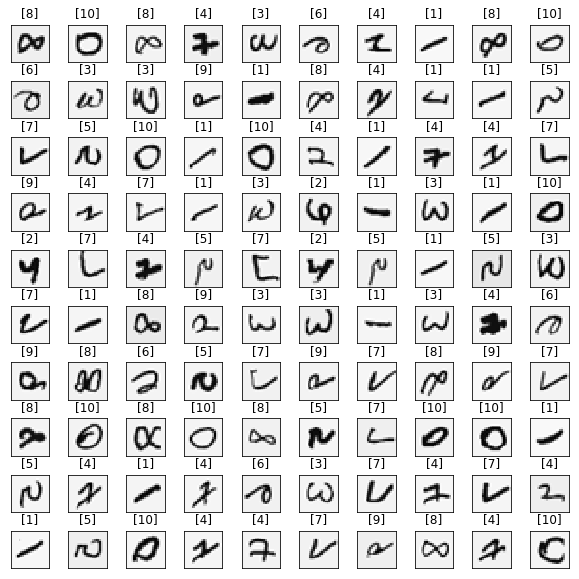

In [5]:
plot_100_image(X)

## 发现图像的x,y坐标轴需要调换一下

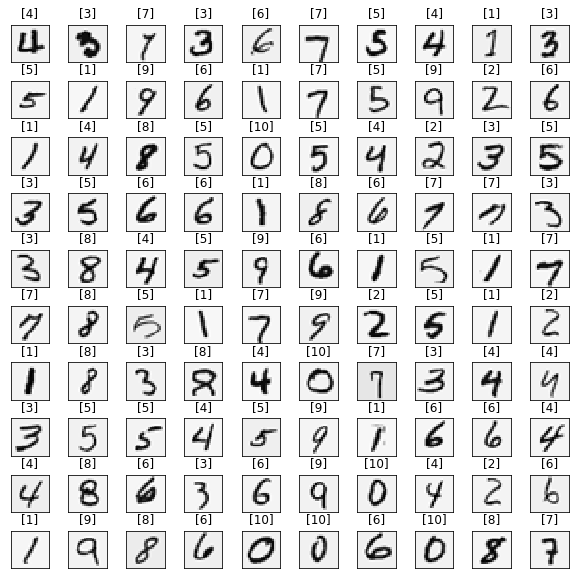

In [6]:
X=np.array([x.reshape(20,20).T for x in X ])
X=np.array([x.reshape(400) for x in X])
plot_100_image(X)

## 把y(5000,1)转化为y_onehot(5000,10)

In [7]:
encoder=OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [8]:
y_onehot[0],y[0]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([10], dtype=uint8))

## 分训练集和测试集

In [21]:
import random
random_num=random.sample(range(5000),5000)
X_train=X[random_num[:4000],:]
y_train=y_onehot[random_num[:4000]]

X_train.shape,y_train.shape

((4000, 400), (4000, 10))

In [52]:
X_test=X[random_num[4000:],:]
# 注意！这里的y_test不是在y_onrhot里选择！
y_test=y[random_num[4000:]]

X_test.shape,y_test.shape

((1000, 400), (1000, 1))

In [25]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [26]:
def load_theta(path):
    data=loadmat(path)
    t1,t2=data['Theta1'],data['Theta2']
    return np.matrix(t1),np.matrix(t2)


In [27]:
t1,t2=load_theta('ex4weights.mat')
t1.shape,t2.shape

((25, 401), (10, 26))

In [28]:
def serialize(a, b):
  
    return np.concatenate((np.ravel(a), np.ravel(b)))

In [29]:
theta_all=serialize(t1,t2)

In [30]:
def deserialize(theta_all):
    return theta_all[:25*401].reshape(25,401),theta_all[25*401:].reshape(10,26)

## 定义前馈函数fp

In [31]:
def fp(X,theta_all):
    theta1,theta2=deserialize(theta_all)
    a1=np.insert(X,0,np.ones(len(X)),axis=1)
    z2=a1@theta1.T
    a2=np.insert(sigmoid(z2),0,np.ones(len(z2)),axis=1)
    z3=a2@theta2.T
    h=sigmoid(z3)
    return a1,z2,a2,z3,h


### 代价函数的theta 参数需要经过serialize处理，因为这样才能方便优化函数处理

In [32]:
def cost(theta_all,X,y):
    
    _,_,_,_,h=fp(X,theta_all)
    first=np.multiply(-y,np.log(h))
    secend=np.multiply(-(1-y),np.log(1-h))
    return (first+secend).sum()/len(X)


In [33]:
cost(theta_all,X_train,y_train)

5.8192472139511651

In [34]:
def regularized_cost(theta_all,X,y,learning_rate=1):
    """
    正则化的代价函数
    """
    t1,t2=deserialize(theta_all)
    r_cost=learning_rate/2/len(X)*np.power(t1[:,1:],2).sum()+learning_rate/2/len(X)*np.power(t2[:,1:],2).sum()
    return cost(theta_all,X,y)+r_cost

In [35]:
regularized_cost(theta_all,X_train,y_train)

5.939423081363171

## 接下来就是写梯度相关的函数

In [36]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

In [37]:
sigmoid_gradient(0)

0.25

In [38]:
def gradient(theta_all,X,y):
    t1,t2=deserialize(theta_all)
    a1,z2,a2,z3,h=fp(X,theta_all)
    
    detal1,detal2=np.zeros(t1.shape),np.zeros(t2.shape)
    for i in range(len(X)):
        a1i=a1[i,:] # (1,401)
        z2i=np.insert(z2[i,:],0,np.ones(1)) #(1,26)
        a2i=a2[i,:] #(1,26)
        hi=h[i,:] #(1,10)
        yi=y[i,:] #(1,10)
        
        d3=hi-yi #(1,10)
        d2=np.multiply(d3@t2, sigmoid_gradient(z2i)) #(1,26)
        
        detal1+=np.matrix(d2[1:]).T@np.matrix(a1i)
        detal2+=np.matrix(d3).T@np.matrix(a2i)
    detal1,detal2=detal1/len(X),detal2/len(X)
    return serialize(detal1,detal2)


In [39]:
gradient(theta_all,X_train,y_train).shape

(10285,)

In [40]:
def regularized_gradient(theta_all,X,y,learning_rate=1):
    t1,t2=deserialize(theta_all)
    detal1,detal2=deserialize(gradient(theta_all,X,y))
    
    detal1[:,1:]+=t1[:,1:]*learning_rate/len(X)
    detal2[:,1:]+=t2[:,1:]*learning_rate/len(X)
    
    return serialize(detal1,detal2)
    
    

In [41]:
regularized_gradient(theta_all,X_train,y_train).shape

(10285,)

## 梯度检验

In [42]:
def expand_array(arr):
    """
    将array([1,2,3])扩展成
    array([[ 1.,  2.,  3.],
          [ 1.,  2.,  3.],
          [ 1.,  2.,  3.]])
     """
    
    return np.array(np.matrix(np.ones(len(arr))).T@np.matrix(arr))

In [43]:
def gradient_checking(theta_all,X,y,epsilon,regularized=False):
    def a_numeric_grad(plus,mins,regularized):
        if regularized:
            return (regularized_cost(plus,X,y)-regularized_cost(mins,X,y))/2/epsilon
        else:
            return (cost(plus,X,y)-cost(mins,X,y))/2/epsilon
    theta_matrix=expand_array(theta_all) #expand to (10285,10285)
    epsilon_matrix=np.identity(len(theta_all))*epsilon
    
    plus_matrix=theta_all+epsilon_matrix
    minus_matrix=theta_all-epsilon_matrix
    
    numeric_grad = np.array([a_numeric_grad(plus_matrix[i,:],minus_matrix[i,:],regularized) for i in range(len(theta_all))])
    analytic_grad = regularized_gradient(theta_all,X,y) if regularized else gradient(theta_all,X,y)
    
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)

    print('估计梯度与实际梯度的相对差距diff 应该小于 10e-9 (如果 epsilon=0.0001).\n相对差距: {}\n'.format(diff))
    
    
    

In [44]:
# gradient_checking(theta_all, X, y_onehot, epsilon=0.0001, regularized=True)      # 这个函数执行很慢

# 训练模型

In [45]:
def random_init(size):
    # 在均匀分布中随机采样
    return np.random.uniform(-0.12, 0.12, size)


## 注意，如果opt.minimize中的fun 和 jac中 的函数的第一个参数（即regularized_cost和regularized_gradient的第一个参数）不是X0,则会出错

In [46]:
def nn_training(X, y):
    """regularized version
    the architecture is hard coded here... won't generalize
    """
    init_theta = random_init(10285)  # 25*401 + 10*26

    res = opt.minimize(fun=regularized_cost,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'maxiter': 400})
    return res

In [47]:
res=nn_training(X_train,y_train)
res

     fun: 0.34847947479967367
     jac: array([ -3.27227178e-04,  -9.12357616e-07,  -2.09611120e-07, ...,
         3.38317550e-05,   1.44980285e-05,  -1.73495779e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 27
  status: 3
 success: False
       x: array([  6.56487423e-01,  -3.64943046e-03,  -8.38428705e-04, ...,
        -3.32206781e+00,   1.48024202e+00,  -1.13739598e+00])

# 显示准确率

In [48]:

def show_accuracy(theta_all,X,y):
    _, _, _, _, h = fp(X, theta_all)

    y_pred = np.argmax(h, axis=1) + 1

    print(classification_report(y,y_pred))


In [53]:
final_theta=res.x

show_accuracy(final_theta,X_test,y_test)

             precision    recall  f1-score   support

          1       0.94      0.96      0.95       114
          2       0.98      0.90      0.94       107
          3       0.95      0.93      0.94        99
          4       0.93      0.95      0.94       110
          5       0.92      0.89      0.90       109
          6       0.94      0.90      0.92        81
          7       0.95      0.94      0.94        80
          8       0.86      0.92      0.89        95
          9       0.87      0.88      0.88       101
         10       0.94      0.98      0.96       104

avg / total       0.93      0.93      0.93      1000

